### Classifiers: Playing with MNIST

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

- Data - arrays of the pixel values of each digit
- Target - array of all the labels
- DESCR - describes the dataset


In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape  # 70,000 rows, and each image is 784 pixels (28 x 28)

(70000, 784)

In [4]:
y.shape

(70000,)

#### Visualize a digit 

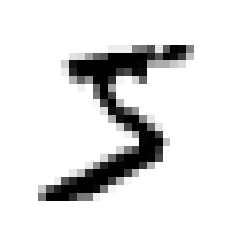

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#some_digit = X[36000]
some_digit = X[0]

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
y[0]  # turns out to be a 5, NOICE

'5'

In [7]:
# cast y to integers
y = y.astype(np.uint8)

In [151]:
y[0]

5

In [9]:
# MNIST is already split into a test and train for us
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's try to identify one digit - fives (5 or not-5)

In [39]:
y_train_5 = (y_train == 5) # True for all 5's, False for all other digits
y_test_5 = (y_test == 5)

In [40]:
np.unique(y_train_5)

array([False,  True])

In [176]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
#sgd_clf.fit(X_train, y_train_5)

In [45]:
mnist['target'][0:20]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7', '2', '8', '6', '9'], dtype=object)

In [46]:
sgd_clf.predict(mnist['data'][0:20])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

from sklearn.model_selection import cross_val_score
cross_val_scoree(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [47]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

**This seems great, but a dummy classifier that would just make _everything_ a 'not-5' category would score more than 90%, bc only roughly 10% of the digits are fives.**

**Therefore, accuracy is _not_ the preferred measurement of performance, particularly when the datasets can be skewed (when some classes are much more frequent than others).**

## Confusion Matrix to the rescue!

In [48]:
# cross_val_predict will return the predictions made on each test fold. We retrieve the predictions like soo:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [51]:
# to get confusion matrix we just pass the target classes and the predicted classes into the function
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Explanation of confustion matrix results:

### PRECISION = TP / (TP + FP)
### RECALL = TP / (TP + FN)         also called sensitivity or true positive rate

In [53]:
# So a perfect model will return something like this:
y_train_perfect_predictions = y_train_5 #...pretending we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Now let's compute precision and recall with some built-in methods

In [54]:
confusion_matrix

<function sklearn.metrics.classification.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)>

In [55]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_true=y_train_5,
               y_pred=y_train_pred)  # so this is computing 3530 / (3530 + 687)

0.8370879772350012

In [56]:
recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891)

0.6511713705958311

#### An F-Score compares both recall and precision and is a quick way to compare two classifiers

The 'harmonic mean' between precision and recall - only gives high score if both precision and recall are high

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Increasing precision reduces recall and vice/versa.... known as the _precision/recall tradeoff_

##### Playing with threshold

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [59]:
threshold = 0  #SGDClassifier uses threshold equal to zero
y_some_digit_pred = (y_scores > threshold)

In [61]:
y_some_digit_pred

array([ True])

In [62]:
# Let's raise the threshold
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred  # raising the threshold decreased recall

array([False])

#### How to determine which threshold?

In [75]:
# get scores of all instances in the training set with cross val predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [76]:
# now compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

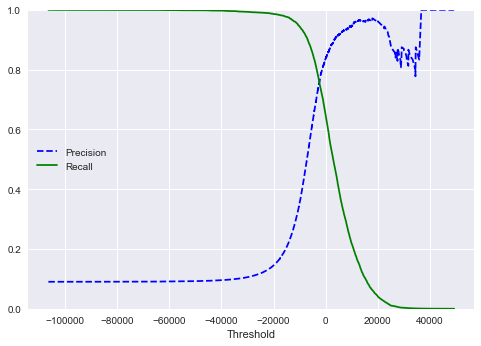

In [77]:
# a  little function to help us plot...
plt.style.use('seaborn')
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [102]:
# if we were aiming for 90% precision, instead of re-running predict method with new thresh, could do this instead:
y_train_pred_90 = (y_scores > 35970)

In [103]:
precision_score(y_train_5, y_train_pred_90) # not quite 90 but close

0.8333333333333334

In [101]:
y_train_pred_90 = y_scores > 40000
thresh = 40000
while precision_score(y_train_5, y_train_pred_90) > 0.9:
    y_train_pred_90 = (y_scores > thresh)
    thresh -=10
    #print(precision_score(y_train_5, y_train_pred_90))
print(thresh)

35970


### ROC Curve - another good tool with binary classifiers

In [107]:
#plots true positive rate (TPR) against the false positive rate (FPR)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)\

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

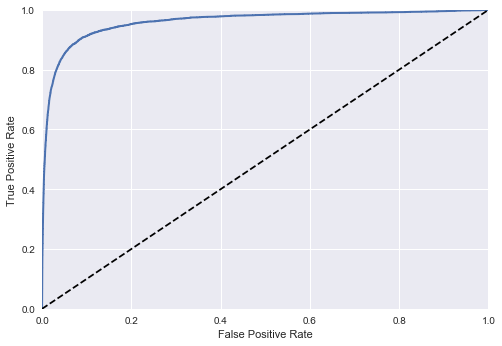

In [108]:
plot_roc_curve(fpr, tpr)
plt.show()

##### A good classifier will stay well away from the middle line, ideally in top left corner. Looking at the area under the curve (AUC) score is a good way to compare classifiers.

In [109]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Use the PR curve when positive class is rare, otherwise use ROC AUC

##### Compare a Random Forest Classifier vs SGD

In [110]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [117]:
y_probas_forest # THIS ARRAY- TWO COLUMNS: EACH COLUMN IS PROBABILITY OF THAT INSTANCE BELONGING TO ONE CLASS OR THE OTHER

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

In [118]:
# TO plot a ROC curve, you need scores, not probabilities
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

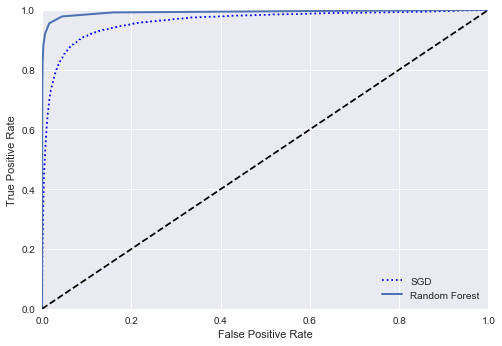

In [120]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [121]:
# RF looks much better... plus ROC AUC score will be better too....
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

### Multiclass Classification

Scikit-Learn detects when you try to use binary classification algorithm for a multi-class task and it will use One vs All

In [183]:
sgd_clf.fit(X_train, y_train) #y_train, not y_train_5
sgd_clf.predict([some_digit]) # this returns incorrectly for some reason

array([3], dtype=uint8)

In [188]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [186]:
some_digit_scores = sgd_clf.decision_function([X[0]])

In [187]:
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [192]:
for i in range(9):
    print(sgd_clf.predict([X[i]]))
    print('Actual:', y[i])

[3]
Actual: 5
[0]
Actual: 0
[4]
Actual: 4
[1]
Actual: 1
[9]
Actual: 9
[2]
Actual: 2
[1]
Actual: 1
[3]
Actual: 3
[1]
Actual: 1


Can manually force ScikitLearn to do OvO or OvRest... OneVsOneClassifier(SGDClassifier(random_state=42)) etc.
-OR - Just use RF classifier as it is just as easy:

In [193]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])


C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [194]:
# RF correctly identified... can see the prediction probabilities per class by calling:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [195]:
# Check all error with cross_val_score on SGDClassifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87082583, 0.87089354, 0.88628294])

In [197]:
# All fols got above 85%! Not bad but we can improve with scaling.   #Can take 10 minutes   #   got memory warning
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

###### Check the confusion matrix for this task:

In [198]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\604572\Continuum\anaconda3\envs\handson-ml\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

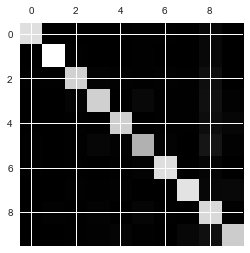

In [199]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

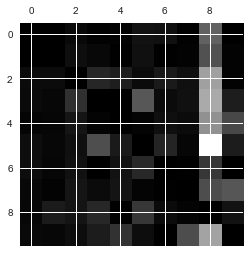

In [200]:
#Focus plot on the errors: divide each value in conf matrix by number of images in the corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    # EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

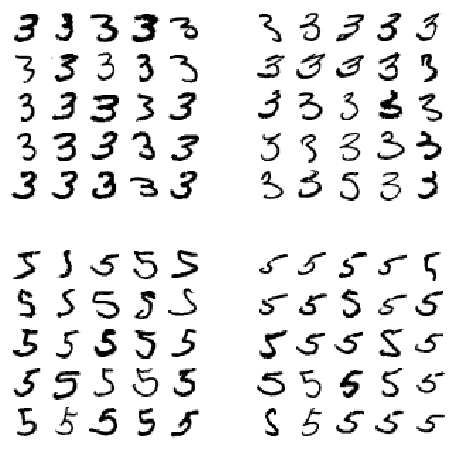

In [208]:
# Analyze individual errors?
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

#### Multilabel Classification

In [15]:
# Example: 
# Looking for Alice, Bob, Charlie faces; sees Alice and Charlie; returns [1,0,1]
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [16]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

NameError: name 'cross_val_predict' is not defined

#### Multioutput Classification

In [10]:
# Build system that removes noise from images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'save_fig' is not defined

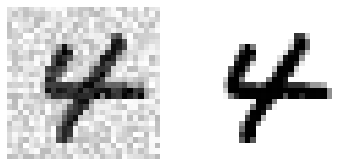

In [13]:
# Inspect random image
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [14]:
# Clean the digit and display it
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

NameError: name 'knn_clf' is not defined